Предсказываю тестовые траектории для каждой активности по min KL между ML-estimation обученных на многих траекториях моделями активностей и вновь натренированной по тестовой траектории модели

In [1]:
import sys
from pathlib import Path
import yaml
from tqdm.notebook import tqdm
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from field_model import *
from optimizer import get_optimizer
from model_distances import *

import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
# load config files for data and pipeline
with open("config.yaml", "r") as f1:
    config = yaml.full_load(f1)

with open("../../data/dataset_params.yaml") as f2:
    data_params = yaml.full_load(f2)

device = torch.device(config["device"])

# dir with trajectories Datasets
traj_dir = Path("trajectories/")
if not traj_dir.exists():
    raise FileNotFoundError("No Dataset created for given activity.")

# ode models
models_dir = Path("models/")

In [3]:
# compute mean and diag log std of the ML estimators
models = {}
for model_file in models_dir.glob("*_sqrt*"):
    activity = model_file.stem

    vector_field = eval(config["model_cls"])(config["trajectory_dim"], **config["model_params"])
    ode_model = NeuralODE(vector_field, solver='rk4').to(device)
    ode_model.load_state_dict(
        torch.load(model_file)
    )

    models[activity] = ode_model

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [11]:
def ml_diag_log_std(ode_model: NeuralODE, train_loader: DataLoader) -> torch.Tensor:
    """ Computes diagonal elements of the Fisher matrix of log(p). It is factorized approximation
            of the ML inversed hessian. Returns diagonal log-std.
    """
    ode_model.zero_grad()
    ode_model.eval()

    num_batches = len(list(iter(train_loader)))

    for batch in tqdm(train_loader, desc="Accumulating grads", leave=False):
        traj: torch.Tensor = batch[0].to(ode_model.device)
        durations: torch.Tensor = batch[1].to(ode_model.device)

        traj_len = traj.shape[1]
        t_span = torch.arange(0, traj_len).to(ode_model.device)
        mask = get_trajectory_mask(durations, traj)

        t_eval, traj_predict = ode_model(traj[:, 0, :], t_span)
        # move batch axis in front
        traj_predict = traj_predict.movedim(1, 0)

        #average loss among all real phase vectors
        log_lh = F.mse_loss(
            traj,
            traj_predict * mask,
            reduction="none"
        )
        log_lh = log_lh.sum(dim=-1)
        # try weightening
        log_lh *= 1 / torch.sqrt(torch.arange(start=1, end=log_lh.shape[1] + 1).to(device))
        log_lh = log_lh.sum(dim=-1) / durations
        log_lh = log_lh.sum() / num_batches

        # accumulate gradients
        log_lh.backward()

    # compute log std out of log(p) gradients (reverse hessian approximation)
    diag_log_std = []
    for param in ode_model.parameters():
        diag_log_std.append(
            - torch.log(param.grad.abs().flatten().detach())
        )
    diag_log_std = torch.concat(diag_log_std)

    # check for errors
    if torch.isnan(diag_log_std).sum() > 0:
        warnings.warn(
            f"{torch.isnan(diag_log_std).sum()
               } NaNs in fisher matrix, change them for zero",
            RuntimeWarning
        )
        diag_log_std = diag_log_std.nan_to_num()

    return diag_log_std

In [12]:
def get_trajectory_mask(durations: torch.Tensor, traj: torch.Tensor) -> torch.Tensor:
    mask = torch.ones_like(traj).to(traj.device)
    for i in range(mask.shape[0]):
        # mask out padding vectors in trajectory
        mask[i, durations[i]: , ...] = 0.

    return mask

In [ ]:
models_ML = {}

for model_name, model in models.items():
        model_activity = model_name.split("_")[0]
        train_loader = DataLoader(
                torch.load(traj_dir / f"{model_activity}_train.pt"),
                config["batch_size"],
                shuffle=True
            )

        mean = vectorize_model_params(model)
        log_std = ml_diag_log_std(model, train_loader)

        models_ML[model_name] = (mean, log_std)

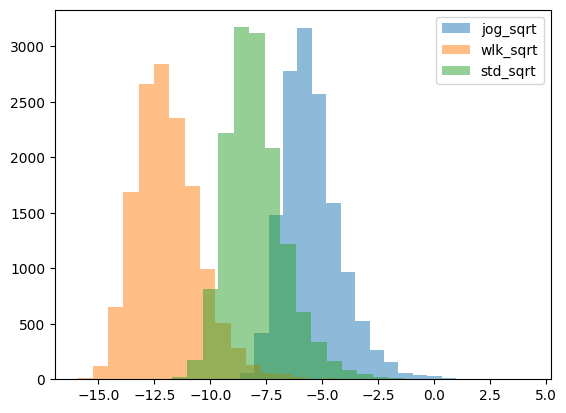

In [20]:
for model_name, ml_estimator in models_ML.items():
    log_std = ml_estimator[1].cpu().numpy()
    plt.hist(log_std, bins=20, label=model_name, alpha=0.5)
    plt.legend()

Classifying jog label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


True label is jog
Distances
 {'jog_sqrt': 110745792.0, 'wlk_sqrt': 42693270962176.0, 'std_sqrt': 10498068480.0}
Minimum is  jog_sqrt


Classifying wlk label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch: 100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


True label is wlk
Distances
 {'jog_sqrt': 103069872.0, 'wlk_sqrt': 76076613107712.0, 'std_sqrt': 16300920832.0}
Minimum is  jog_sqrt


Classifying std label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch: 100%|██████████| 7/7 [00:41<00:00,  5.86s/it]
                                                                   

True label is std
Distances
 {'jog_sqrt': 87789215744.0, 'wlk_sqrt': 5.918825281644134e+16, 'std_sqrt': 25542185189376.0}
Minimum is  jog_sqrt




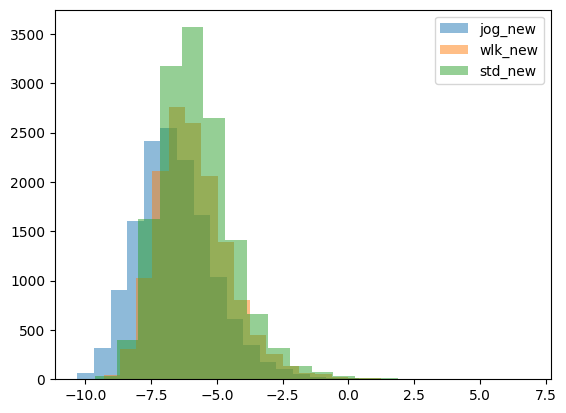

In [27]:
for activity in ["jog", "wlk", "std"]:
    print(f"Classifying {activity} label")

    test_loader = DataLoader(
        torch.load(traj_dir / f"{activity}_test.pt"),
        config["batch_size"],
        shuffle=False
    )

    # create model
    vector_field = eval(config["model_cls"])(config["trajectory_dim"], **config["model_params"])
    ode_model = NeuralODE(vector_field, solver='rk4').to(device)

    # get optimizer
    optim = get_optimizer(ode_model)

    # metrics writer
    writer = SummaryWriter(f"runs/{activity}_test/{datetime.now()}")

    # train loop
    global_step = 0
    for epoch in tqdm(range(config["num_epochs"]), desc="Epoch"):
        ode_model.train()
        for batch in tqdm(test_loader, desc="Train", leave=False):
            optim.zero_grad()

            traj: torch.Tensor = batch[0].to(device)
            durations: torch.Tensor = batch[1].to(device)

            traj_len = traj.shape[1]
            t_span = torch.arange(0, traj_len).to(device)
            mask = get_trajectory_mask(durations, traj)

            t_eval, traj_predict = ode_model(traj[:, 0, :], t_span)
            # move batch axis in front
            traj_predict = traj_predict.movedim(1, 0)

            # average loss among all real phase vectors
            log_lh = F.mse_loss(
                traj,
                traj_predict * mask,
                reduction="none"
            )
            log_lh = log_lh.sum(dim=-1)
            # try weightening
            log_lh *= 1 / torch.sqrt(torch.arange(start=1, end=log_lh.shape[1] + 1).to(device))
            log_lh = log_lh.sum(dim=-1) / durations
            log_lh = log_lh.sum()

            writer.add_scalar("Train/MSE", log_lh.item(), global_step)
            global_step += 1

    writer.close()

    # classifying
    mean_test = vectorize_model_params(ode_model)
    # log_std_test = torch.zeros_like(mean_test)
    log_std_test = ml_diag_log_std(ode_model, test_loader)

    plt.hist(log_std_test.cpu().numpy(), bins=20, label=f"{activity}_new", alpha=0.5)
    plt.legend()

    distances = {}

    for model_name, ml_est in models_ML.items():
        model_activity = model_name.split("_")[0]

        mean, log_std = ml_est
        # log_std = torch.zeros_like(mean)

        distances[model_name] = get_normal_KL(
            mean_test, log_std_test,
            mean, log_std
        ).cpu().item()

    print(f"True label is {activity}")
    print("Distances\n", distances)
    print("Minimum is ", min(distances, key=distances.get))
    print("\n")

In [28]:
for activity in ["jog", "wlk", "std"]:
    print(f"Classifying {activity} label")

    test_loader = DataLoader(
        torch.load(traj_dir / f"{activity}_test.pt"),
        config["batch_size"],
        shuffle=False
    )

    # create model
    vector_field = eval(config["model_cls"])(config["trajectory_dim"], **config["model_params"])
    ode_model = NeuralODE(vector_field, solver='rk4').to(device)

    # get optimizer
    optim = get_optimizer(ode_model)

    # metrics writer
    writer = SummaryWriter(f"runs/{activity}_test/{datetime.now()}")

    # train loop
    global_step = 0
    for epoch in tqdm(range(config["num_epochs"]), desc="Epoch"):
        ode_model.train()
        for batch in tqdm(test_loader, desc="Train", leave=False):
            optim.zero_grad()

            traj: torch.Tensor = batch[0].to(device)
            durations: torch.Tensor = batch[1].to(device)

            traj_len = traj.shape[1]
            t_span = torch.arange(0, traj_len).to(device)
            mask = get_trajectory_mask(durations, traj)

            t_eval, traj_predict = ode_model(traj[:, 0, :], t_span)
            # move batch axis in front
            traj_predict = traj_predict.movedim(1, 0)

            # average loss among all real phase vectors
            log_lh = F.mse_loss(
                traj,
                traj_predict * mask,
                reduction="none"
            )
            log_lh = log_lh.sum(dim=-1)
            # try weightening
            log_lh *= 1 / torch.sqrt(torch.arange(start=1, end=log_lh.shape[1] + 1).to(device))
            log_lh = log_lh.sum(dim=-1) / durations
            log_lh = log_lh.sum()

            writer.add_scalar("Train/MSE", log_lh.item(), global_step)
            global_step += 1

    writer.close()

    # classifying
    mean_test = vectorize_model_params(ode_model)
    log_std_test = torch.zeros_like(mean_test)

    distances = {}

    for model_name, ml_est in models_ML.items():
        model_activity = model_name.split("_")[0]

        mean = ml_est[0]
        log_std = torch.zeros_like(mean)

        distances[model_name] = get_normal_KL(
            mean_test, log_std_test,
            mean, log_std
        ).cpu().item()

    print(f"True label is {activity}")
    print("Distances\n", distances)
    print("Minimum is ", min(distances, key=distances.get))
    print("\n")

Classifying jog label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


True label is jog
Distances
 {'jog_sqrt': 106.02567291259766, 'wlk_sqrt': 107.20480346679688, 'std_sqrt': 106.80850219726562}
Minimum is  jog_sqrt


Classifying wlk label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it]


True label is wlk
Distances
 {'jog_sqrt': 108.12274169921875, 'wlk_sqrt': 104.03038787841797, 'std_sqrt': 105.38868713378906}
Minimum is  wlk_sqrt


Classifying std label
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Epoch: 100%|██████████| 7/7 [00:50<00:00,  7.17s/it]

True label is std
Distances
 {'jog_sqrt': 106.8107681274414, 'wlk_sqrt': 106.44168853759766, 'std_sqrt': 106.21768188476562}
Minimum is  std_sqrt


